# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import plotly.express as px
from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

pd.set_option('display.max_columns', None)


---
## 2. Load data

In [2]:
df = pd.read_csv('client_data.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [4]:
# Get object columns
obj_to_convert = [col for col in df.columns if df[col].dtype == 'object']

# Convert to type category
df[obj_to_convert] = df[obj_to_convert].apply(lambda x: x.astype('category'))

# Conversion confirmation
for col in obj_to_convert:
    assert df[col].dtype == 'category'

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January


In [5]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [6]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


### Based on the premise that pricing discrepancies between months cause churns, I will extract all price differences from the data and confirm or reject that hypothesis.

In [7]:
# Get price difference across periods
# Energy
price_df['price_p1_p2_var_diff'] = price_df.price_peak_var - price_df.price_off_peak_var
price_df['price_p1_p3_var_diff'] = price_df.price_mid_peak_var - price_df.price_off_peak_var
price_df['price_p2_p3_var_diff'] = price_df.price_mid_peak_var - price_df.price_peak_var

# Power
price_df['price_p1_p2_fix_diff'] = price_df.price_peak_fix - price_df.price_off_peak_fix
price_df['price_p1_p3_fix_diff'] = price_df.price_mid_peak_fix - price_df.price_off_peak_fix
price_df['price_p2_p3_fix_diff'] = price_df.price_mid_peak_fix - price_df.price_peak_fix

# Get price change across periods
price_df['price_p1_p2_var_change'] = (price_df.price_peak_var / price_df.price_off_peak_var) - 1
price_df['price_p1_p3_var_change'] = (price_df.price_mid_peak_var / price_df.price_off_peak_var) - 1
price_df['price_p2_p3_var_change'] = (price_df.price_mid_peak_var / price_df.price_peak_var) - 1

price_df['price_p1_p2_fix_change'] = (price_df.price_peak_fix / price_df.price_off_peak_fix) - 1
price_df['price_p1_p3_fix_change'] = (price_df.price_mid_peak_fix / price_df.price_off_peak_fix) - 1
price_df['price_p2_p3_fix_change'] = (price_df.price_mid_peak_fix / price_df.price_peak_fix) - 1

In [8]:
client_churn_info = df[['id','churn']]
price_df = client_churn_info.merge(price_df,on='id', how = "inner")
price_df.head()

,id,churn,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_p1_p2_var_diff,price_p1_p3_var_diff,price_p2_p3_var_diff,price_p1_p2_fix_diff,price_p1_p3_fix_diff,price_p2_p3_fix_diff,price_p1_p2_var_change,price_p1_p3_var_change,price_p2_p3_var_change,price_p1_p2_fix_change,price_p1_p3_fix_change,price_p2_p3_fix_change
0,24011ae4ebbe3035111d65fa7c15bc57,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,-0.022581,-0.05444,-0.031859,-16.226389,-24.339581,-8.113192,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333
1,24011ae4ebbe3035111d65fa7c15bc57,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,-0.022581,-0.05444,-0.031859,-16.226389,-24.339581,-8.113192,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333
2,24011ae4ebbe3035111d65fa7c15bc57,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333
3,24011ae4ebbe3035111d65fa7c15bc57,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333
4,24011ae4ebbe3035111d65fa7c15bc57,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333


In [9]:
price_df.shape

(175149, 21)

In [10]:
price_df.columns

Index(['id', 'churn', 'price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix', 'price_p1_p2_var_diff', 'price_p1_p3_var_diff',
       'price_p2_p3_var_diff', 'price_p1_p2_fix_diff', 'price_p1_p3_fix_diff',
       'price_p2_p3_fix_diff', 'price_p1_p2_var_change',
       'price_p1_p3_var_change', 'price_p2_p3_var_change',
       'price_p1_p2_fix_change', 'price_p1_p3_fix_change',
       'price_p2_p3_fix_change'],
      dtype='object')

In [11]:
data = price_df.merge(df, on='id', how = "inner")
data.head()

,id,churn_x,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_p1_p2_var_diff,price_p1_p3_var_diff,price_p2_p3_var_diff,price_p1_p2_fix_diff,price_p1_p3_fix_diff,price_p2_p3_fix_diff,price_p1_p2_var_change,price_p1_p3_var_change,price_p2_p3_var_change,price_p1_p2_fix_change,price_p1_p3_fix_change,price_p2_p3_fix_change,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn_y
0,24011ae4ebbe3035111d65fa7c15bc57,1,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,-0.022581,-0.05444,-0.031859,-16.226389,-24.339581,-8.113192,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,24011ae4ebbe3035111d65fa7c15bc57,1,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,-0.022581,-0.05444,-0.031859,-16.226389,-24.339581,-8.113192,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,24011ae4ebbe3035111d65fa7c15bc57,1,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
3,24011ae4ebbe3035111d65fa7c15bc57,1,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
4,24011ae4ebbe3035111d65fa7c15bc57,1,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1


In [12]:
data.columns

Index(['id', 'churn_x', 'price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix', 'price_p1_p2_var_diff', 'price_p1_p3_var_diff',
       'price_p2_p3_var_diff', 'price_p1_p2_fix_diff', 'price_p1_p3_fix_diff',
       'price_p2_p3_fix_diff', 'price_p1_p2_var_change',
       'price_p1_p3_var_change', 'price_p2_p3_var_change',
       'price_p1_p2_fix_change', 'price_p1_p3_fix_change',
       'price_p2_p3_fix_change', 'channel_sales', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'date_activ', 'date_end', 'date_modif_prod',
       'date_renewal', 'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'orig

In [13]:
data = data.drop(columns=["churn_x"])

In [14]:
data.rename(columns={"churn_y": "churn"}, inplace=True)
data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_p1_p2_var_diff,price_p1_p3_var_diff,price_p2_p3_var_diff,price_p1_p2_fix_diff,price_p1_p3_fix_diff,price_p2_p3_fix_diff,price_p1_p2_var_change,price_p1_p3_var_change,price_p2_p3_var_change,price_p1_p2_fix_change,price_p1_p3_fix_change,price_p2_p3_fix_change,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,-0.022581,-0.05444,-0.031859,-16.226389,-24.339581,-8.113192,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,24011ae4ebbe3035111d65fa7c15bc57,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389,-0.022581,-0.05444,-0.031859,-16.226389,-24.339581,-8.113192,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
2,24011ae4ebbe3035111d65fa7c15bc57,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
3,24011ae4ebbe3035111d65fa7c15bc57,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
4,24011ae4ebbe3035111d65fa7c15bc57,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383,-0.022581,-0.05444,-0.031859,-16.226395,-24.339590,-8.113195,-0.179248,-0.432146,-0.308129,-0.4,-0.6,-0.333333,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.0,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1


### We now have a dataset with all the columns available and the differences in prices for energy and power across time.

### Let us consider whether the customer's contract time span is significant. Is it true that younger clients are more inclined to churn? Will clients opt out of receiving the service when the renewal deadline arrives? Do recent product modifications have an impact on churn?

In [15]:
# Get date durations
data['contract_duration'] = data.date_end - data.date_activ
data['next_renewal'] = data.date_renewal - data.date_activ
data['days_since_modif_prod'] = data.date_modif_prod - data.date_activ

In [16]:
# Convert new date durations to int
data['contract_duration'] = data.contract_duration.dt.days
data['next_renewal'] = data.next_renewal.dt.days
data['days_since_modif_prod'] = data.days_since_modif_prod.dt.days

In [17]:
data.groupby('churn').agg({'contract_duration': 'mean', 'next_renewal': 'mean', 'days_since_modif_prod': 'mean'})

,contract_duration,next_renewal,days_since_modif_prod
churn,,,
0,2022.340571,1649.904272,703.735074
1,1871.481739,1498.668588,717.137623


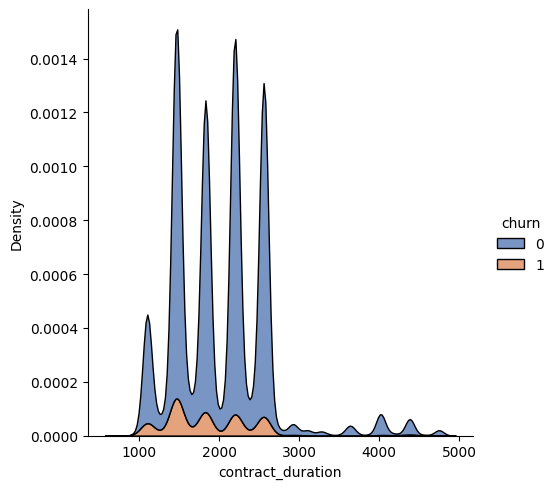

In [18]:
sns.displot(data=data, x="contract_duration", hue="churn", multiple="stack", kind="kde", palette="deep")

### As we can see above, churn is concentrated among clients with 1000 to 3000 days of contract.

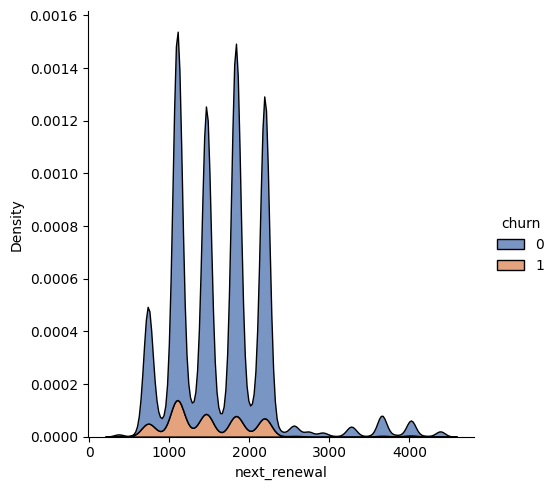

In [19]:
sns.displot(data=data, x="next_renewal", hue="churn", multiple="stack", kind="kde", palette="deep")

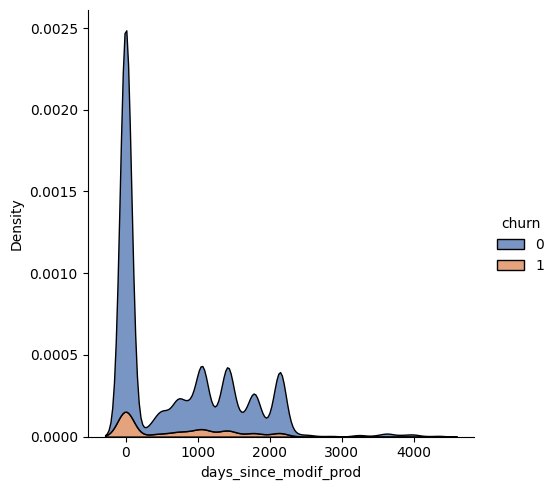

In [20]:
sns.displot(data=data, x="days_since_modif_prod", hue="churn", multiple="stack", kind="kde", palette="deep")

### Testing the statistical significance of the correlations that appear to exist in contract duration x churn, contract renewal x churn and product modification x churn

In [21]:

# Calculate Pearson correlation between 'contract_duration' and 'churn'
correlation, p_value = stats.pearsonr(data['contract_duration'], data['churn'])

# Set Significance Level (alfa)
alfa = 0.05

print(f"Person correlation: {correlation}")
print(f"p-value: {p_value}")

if p_value < alfa:
    print("Reject H0: There is a significant correlation between contract time and churn")
else:
    print("Do not reject H0: There is not enough evidence to conclude that contract time affects churn")


Person correlation: -0.07383703963543004
p-value: 3.115230931802894e-210
Reject H0: There is a significant correlation between contract time and churn


In [22]:

# Calculate Pearson correlation between 'next_renewal' and 'churn'
correlation, p_value = stats.pearsonr(data['next_renewal'], data['churn'])

# Set Significance Level (alfa)
alfa = 0.05

print(f"Person correlation: {correlation}")
print(f"p-value: {p_value}")

if p_value < alfa:
    print("Reject H0: There is a significant correlation between renewal time and churn")
else:
    print("Do not reject H0: There is not enough evidence to conclude that renewal affects churn")

Person correlation: -0.07358011689381942
p-value: 8.777097716629498e-209
Reject H0: There is a significant correlation between renewal time and churn


In [23]:

# Calculate Pearson correlation between 'days_since_modif_prod' and 'churn'
correlation, p_value = stats.pearsonr(data['days_since_modif_prod'], data['churn'])

# Set Significance Level (alfa)
alfa = 0.05

print(f"Person correlation: {correlation}")
print(f"p-value: {p_value}")

if p_value < alfa:
    print("Reject H0: There is a significant correlation between renewal time and churn")
else:
    print("Do not reject H0: There is not enough evidence to conclude that renewal affects churn")

Person correlation: 0.004700164917829147
p-value: 0.04917701472623166
Reject H0: There is a significant correlation between renewal time and churn


### All tests were statistically significant, indicating a link between contract time, contract renewal date, product modification date and churn.

---
# 4. Modeling - Random Forest Classifier

In [24]:
X = data.drop(columns=["churn"])
y = data["churn"]

### separating data into training and test
### Since churn is an imbalanced class, we include the stratify argument

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,  stratify=y, random_state=314)

In [26]:
X_train.isnull().sum()

id                                    0
price_date                            0
price_off_peak_var                    0
price_peak_var                        0
price_mid_peak_var                    0
price_off_peak_fix                    0
price_peak_fix                        0
price_mid_peak_fix                    0
price_p1_p2_var_diff                  0
price_p1_p3_var_diff                  0
price_p2_p3_var_diff                  0
price_p1_p2_fix_diff                  0
price_p1_p3_fix_diff                  0
price_p2_p3_fix_diff                  0
price_p1_p2_var_change              211
price_p1_p3_var_change              211
price_p2_p3_var_change            58516
price_p1_p2_fix_change              891
price_p1_p3_fix_change              891
price_p2_p3_fix_change            75882
channel_sales                         0
cons_12m                              0
cons_gas_12m                          0
cons_last_month                       0
date_activ                            0


In [27]:
categorical_cols = X.select_dtypes(include='category').columns.to_list()
numerical_cols = X.select_dtypes(include='number').columns.to_list()

In [36]:
from sklearn.metrics import roc_auc_score

n_estimators_values = [5, 50, 100, 150, 200]

roc_auc_results_train = []  # Para armazenar os resultados nos dados de treino
roc_auc_results_test = []   # Para armazenar os resultados nos dados de teste

for n_estimators in n_estimators_values:
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')), 
                ('scaler', StandardScaler()) 
            ]), numerical_cols),
            ('cat', OneHotEncoder(drop='first'), categorical_cols)
        ])
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=50, random_state=314))
    ])
    
    # model training
    pipeline.fit(X_train, y_train)
    
    # predictions on train data
    y_scores_train = pipeline.predict_proba(X_train)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_scores_train)
    roc_auc_results_train.append((n_estimators, roc_auc_train))
    
    # predictions on test data
    y_scores_test = pipeline.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_scores_test)
    roc_auc_results_test.append((n_estimators, roc_auc_test))

# Results on train data
print("Results on train data:")
for n_estimators, roc_auc_train in roc_auc_results_train:
    print(f'n_estimators={n_estimators}, ROC-AUC (treino): {roc_auc_train}')

# Results on test data
print("Results on test data:")
for n_estimators, roc_auc_test in roc_auc_results_test:
    print(f'n_estimators={n_estimators}, ROC-AUC (teste): {roc_auc_test}')


Results on train data:
n_estimators=5, ROC-AUC (treino): 0.9618688129926283
n_estimators=50, ROC-AUC (treino): 0.9885670875148012
n_estimators=100, ROC-AUC (treino): 0.9894500041001075
n_estimators=150, ROC-AUC (treino): 0.9897711417465321
n_estimators=200, ROC-AUC (treino): 0.9900983519116074
Results on test data:
n_estimators=5, ROC-AUC (teste): 0.9446944939603864
n_estimators=50, ROC-AUC (teste): 0.9800712687433596
n_estimators=100, ROC-AUC (teste): 0.981413244386502
n_estimators=150, ROC-AUC (teste): 0.9818813123873392
n_estimators=200, ROC-AUC (teste): 0.9823330588729368
